# Loan Status Prediction and Analysis

(dataset from Kaggle)

---

The dataset contains the following columns:

*   Loan_ID: A unique identifier for each loan.
*   Gender: Gender of the applicant.
*   Married: Marital status of the applicant.
*   Dependents: Number of dependents.
*   Education: Education level of the applicant.
*   Self_Employed: Whether the applicant is self-employed or not.
*   ApplicantIncome: Income of the applicant.
*   CoapplicantIncome: Income of the co-applicant.
*   LoanAmount: Loan amount in thousands.
*   Loan_Amount_Term: Term of loan in months.
*   Credit_History: Credit history as per records.
*   Property_Area: Area of property.
*   Loan_Status: Loan approval status (target variable).

In [34]:
# We will explore the data and build some classification models to see which works best for predicting the loan status

# First we will import some packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

### Upload Dataset

In [2]:
# Google Colab file upload formatting

from google.colab import files

uploaded = files.upload()

#Kaggle formatting

#data = pd.read_csv('/kaggle/input/...')

#Juptyer notebook formatting

#data = pd.read_csv('/Users/billypacetti/Desktop/Datasets')

Saving loan_data.csv to loan_data.csv


In [3]:
# Check that the dataframe uploaded properly and assign to a variable

data = pd.read_csv('loan_data.csv')

data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [4]:
# Get a summary of the dataframe

data.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Columns: 13 entries, Loan_ID to Loan_Status
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


### Data Cleaning

In [5]:
# Check the shape of the data

data.shape

(381, 13)

In [6]:
# Check data types to see if variables are numeric or string

data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [7]:
# Check how many unique values are in each column for categorical variables

data.nunique()

Loan_ID              381
Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      322
CoapplicantIncome    182
LoanAmount           101
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64

In [8]:
# Drop the Loan_ID identifier column

data = data.drop(['Loan_ID'], axis=1)

In [9]:
# Check for missing data

data.isnull().sum()

Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64

In [10]:
# Separate the categorical variables

cat_var = data.select_dtypes(include='O').columns.tolist()

cat_var

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [11]:
# Use mode to handle missing data in categorical variables

data[cat_var] = data[cat_var].fillna(data[cat_var].mode().iloc[0])

In [12]:
# Separate the numerical variables

num_var = data.select_dtypes(include='number').columns.tolist()

num_var

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [13]:
# Use median to handle missing data in numerical variables

data[num_var] = data[num_var].fillna(data[num_var].median().iloc[0])

In [14]:
# Check for missing data

data.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [15]:
# Check for duplicate data

data.duplicated().sum()

0

In [16]:
# Print the unique values for the categorical variables

for var in cat_var:
  unique_values = data[var].unique()
  print(f'Unique values in {var}: {unique_values}')

Unique values in Gender: ['Male' 'Female']
Unique values in Married: ['Yes' 'No']
Unique values in Dependents: ['1' '0' '2' '3+']
Unique values in Education: ['Graduate' 'Not Graduate']
Unique values in Self_Employed: ['No' 'Yes']
Unique values in Property_Area: ['Rural' 'Urban' 'Semiurban']
Unique values in Loan_Status: ['N' 'Y']


In [17]:
# Dependents and Property_Area will be handled separately, the rest will be one-hot encoded

data['Dependents'] = data['Dependents'].replace(['0','1','2','3+'],[0,1,2,3])

data['Property_Area'] = data['Property_Area'].replace(['Rural','Urban','Semiurban'],[0,1,2])

data.dtypes

Gender                object
Married               object
Dependents             int64
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status           object
dtype: object

In [18]:
# One-hot encode the binary categorical variables

binary_var = data.select_dtypes(include='O').columns.tolist()

data = pd.get_dummies(data, columns=binary_var, drop_first=True)

data.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Loan_Status_Y
0,1,4583,1508.0,128.0,360.0,1.0,0,1,1,0,0,0
1,0,3000,0.0,66.0,360.0,1.0,1,1,1,0,1,1
2,0,2583,2358.0,120.0,360.0,1.0,1,1,1,1,0,1
3,0,6000,0.0,141.0,360.0,1.0,1,1,0,0,0,1
4,0,2333,1516.0,95.0,360.0,1.0,1,1,1,1,0,1


In [19]:
# Check the final shape of data

data.shape

(381, 12)

## Exploratory Data Analysis

### Summary Statistics

In [20]:
# Get the summary statistics

data.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Loan_Status_Y
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,0.666667,3579.845144,1277.275381,104.986877,427.251969,263.212598,1.112861,0.776903,0.598425,0.270341,0.091864,0.711286
std,0.987643,1419.813818,2340.818114,28.358464,506.204218,898.640716,0.811346,0.416870,0.490861,0.444720,0.289213,0.453761
min,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2600.000000,0.000000,90.000000,360.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3333.000000,983.000000,110.000000,360.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,4288.000000,2016.000000,127.000000,360.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,3.000000,9703.000000,33837.000000,150.000000,3333.000000,3333.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Univariate Statistics

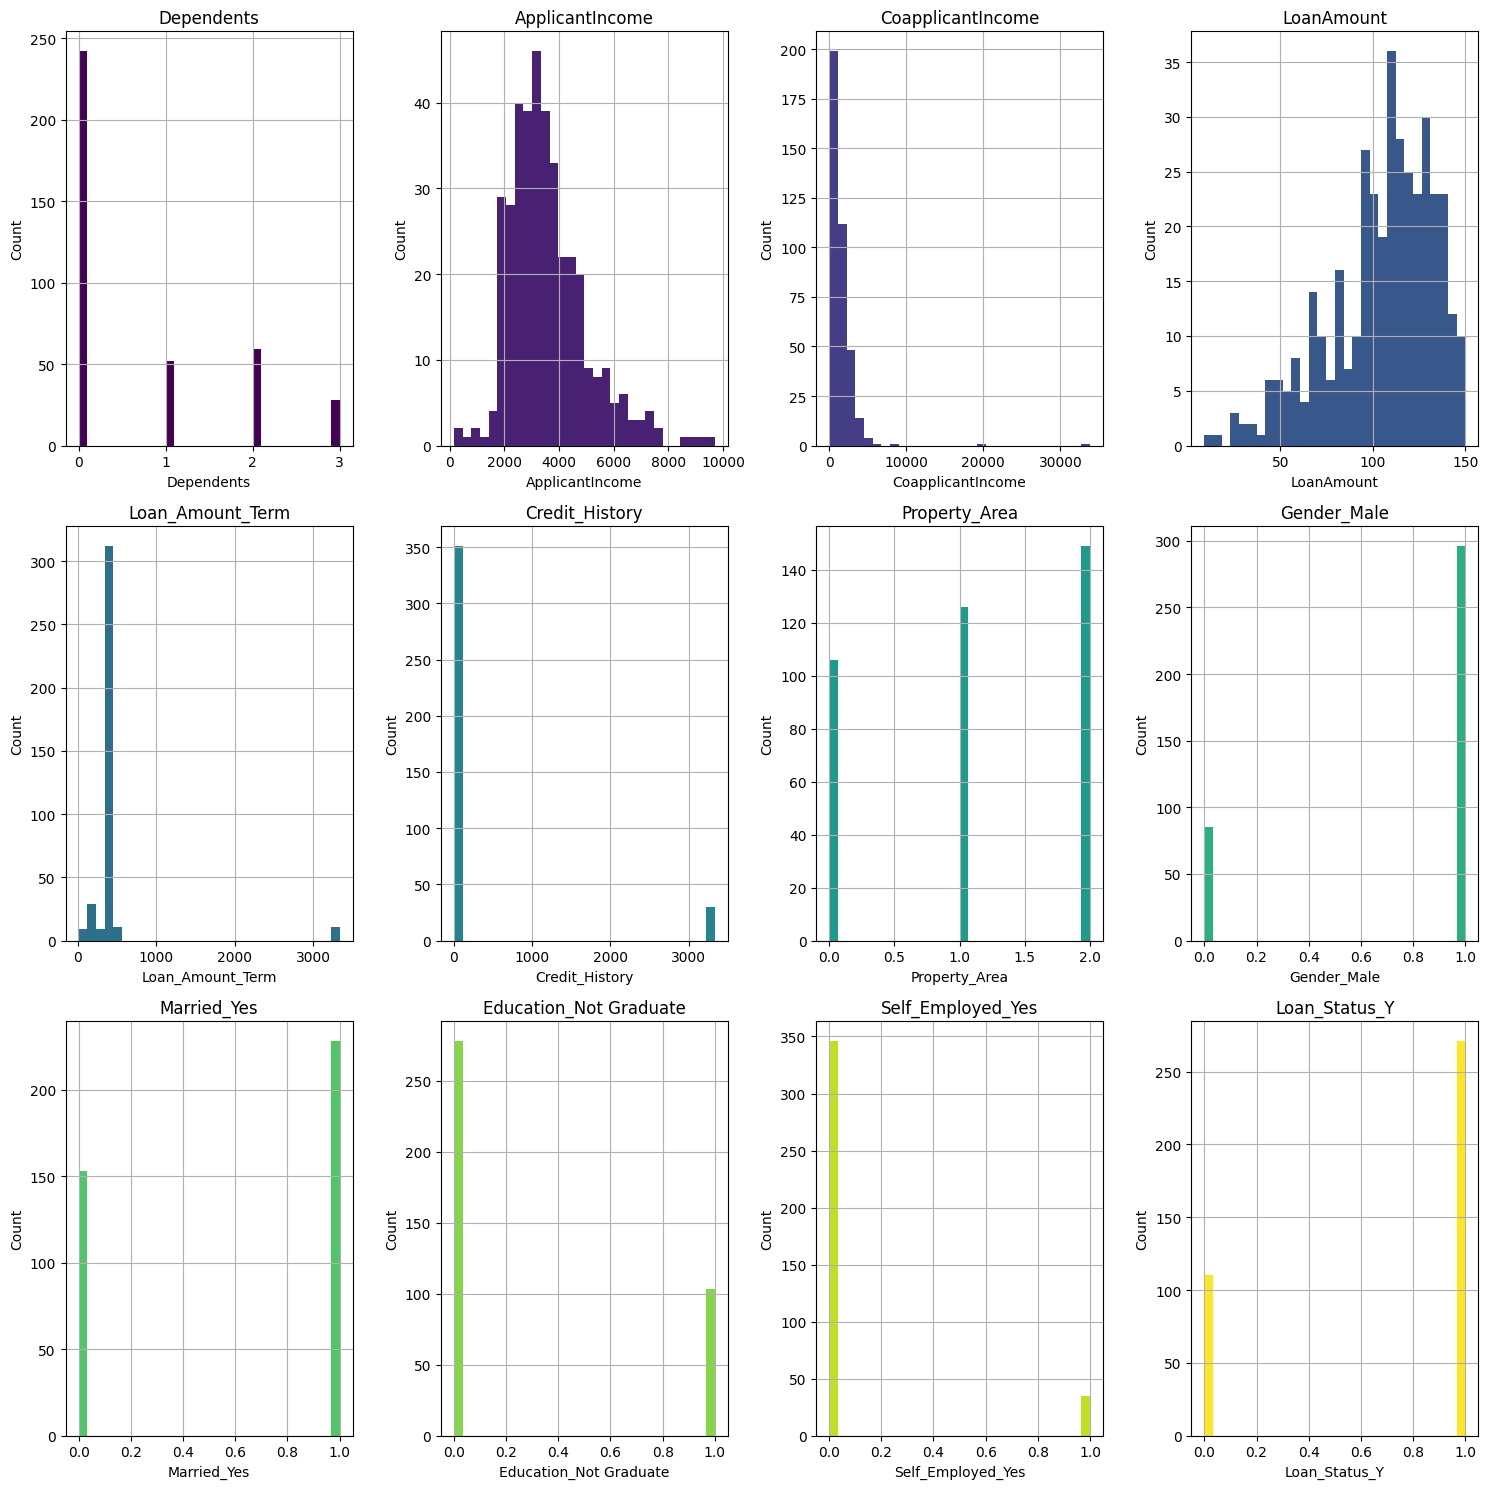

In [21]:
# We will check the frequencies of the variables using histogram charts

# Wrap the charts to 4 per row since there are 12 plots
num_cols = len(data.columns)
plots_per_row = 4
num_rows = (num_cols + plots_per_row - 1) // plots_per_row

# Define the custom colors
colors = plt.cm.viridis(np.linspace(0, 1, num_cols))

# Create the subplots with proper spacing
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 5*num_rows))
fig.subplots_adjust(hspace=0.5) # Adjust the vertical spacing

# Iterate through the columns and plot histograms
for i, (col, color) in enumerate(zip(data.columns, colors)):
  row_index, col_index = divmod(i, plots_per_row)
  ax = axes[row_index, col_index]
  data[col].hist(bins=30, ax=ax, color=color)

  # Set the axis labels and titles
  ax.set_xlabel(col)
  ax.set_ylabel('Count')
  ax.set_title(col)

# Adjust the layout to prevent overlapping titles
plt.tight_layout()
plt.show()

### Bivariate Statistics

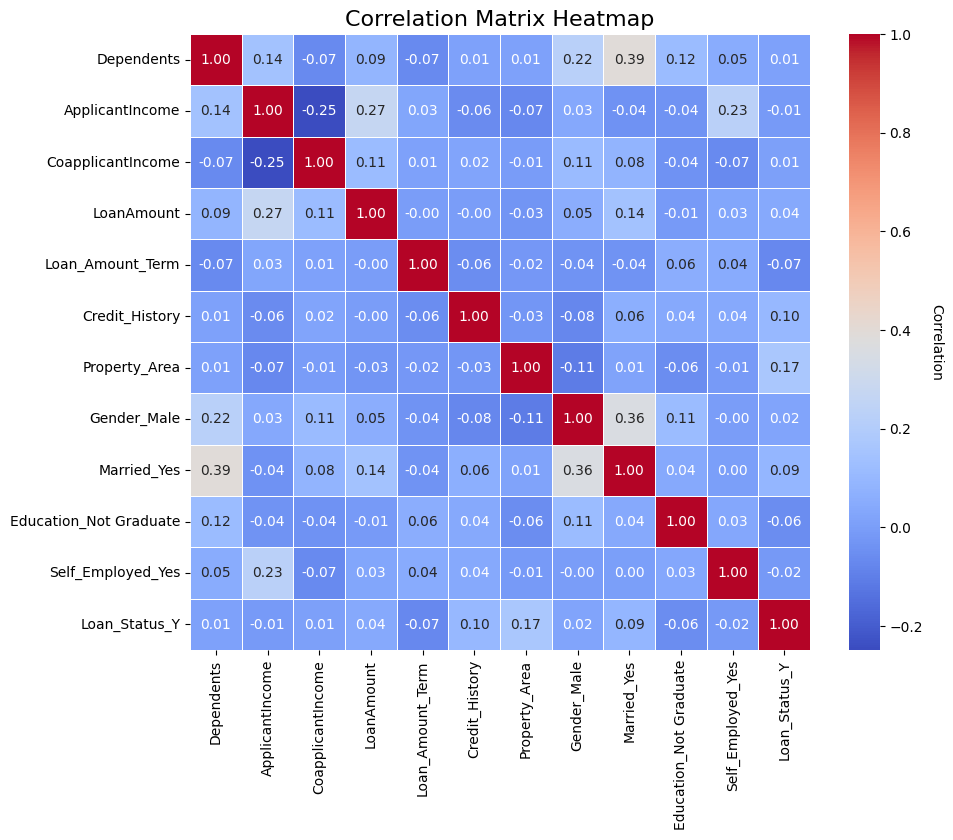

In [22]:
# Calculate correlation matrix

correlation_matrix = data.corr()

# Create a heatmap

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 10})
heatmap.set_title("Correlation Matrix Heatmap", fontsize=16)

# Add a colorbar

cbar = heatmap.collections[0].colorbar
cbar.set_label('Correlation', rotation=270, labelpad=15)

plt.show()

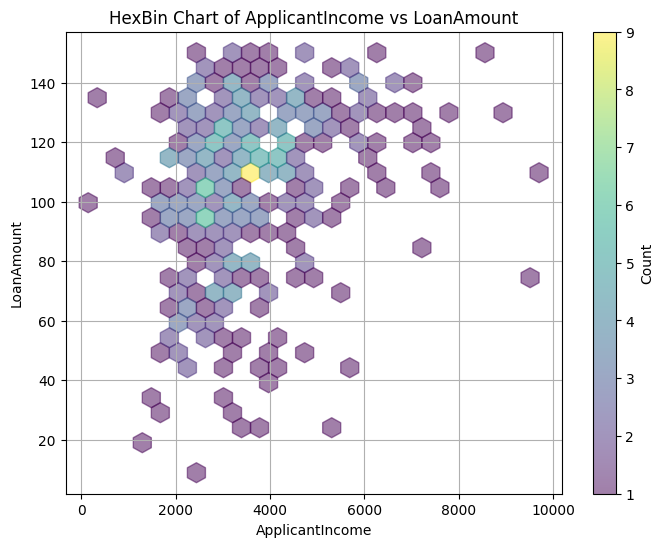

In [23]:
# Visualize hexagonal bin chart of ApplicantIncome and LoanAmount

plt.figure(figsize=(8, 6))
plt.hexbin(x=data['ApplicantIncome'], y=data['LoanAmount'], gridsize=25, cmap='viridis', mincnt=1, alpha=0.5)
plt.title('HexBin Chart of ApplicantIncome vs LoanAmount')
plt.xlabel('ApplicantIncome')
plt.ylabel('LoanAmount')
plt.colorbar(label='Count')
plt.grid(True)
plt.show()

In [24]:
column_names = data.columns.tolist()
print(column_names)

['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Gender_Male', 'Married_Yes', 'Education_Not Graduate', 'Self_Employed_Yes', 'Loan_Status_Y']


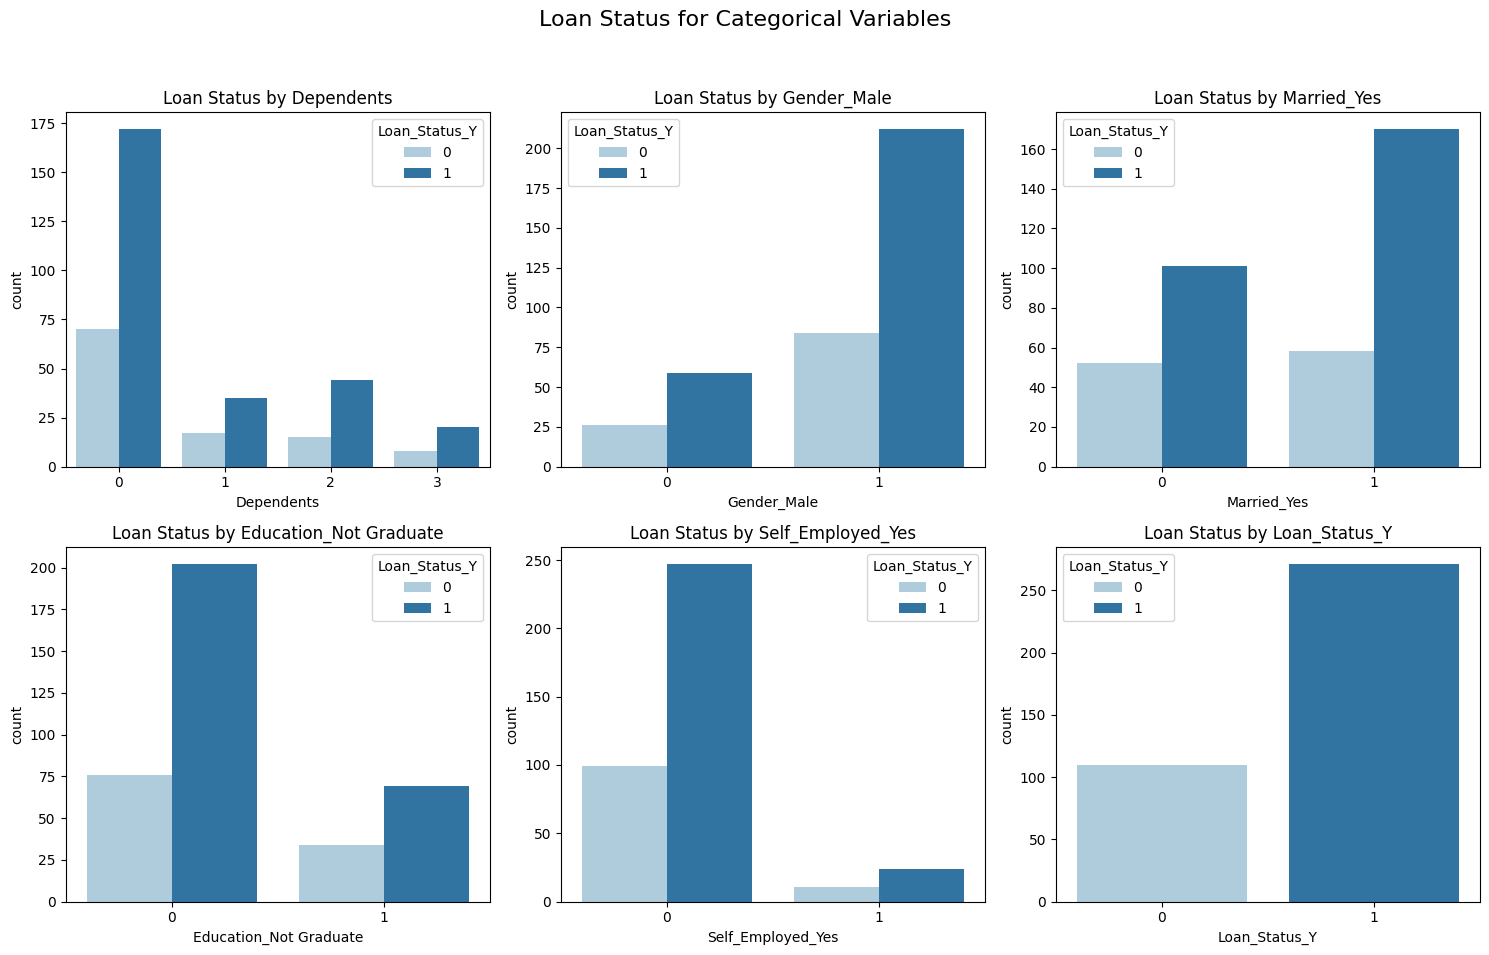

In [25]:
# Select categorical variables
cat_vars = ['Dependents', 'Gender_Male', 'Married_Yes', 'Education_Not Graduate', 'Self_Employed_Yes', 'Loan_Status_Y']

# Create subplots for each categorical variable
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Loan Status for Categorical Variables', fontsize=16)

# Loop through categorical variables for visualization
for i, cat_var in enumerate(cat_vars):
    row, col = i // 3, i % 3
    sns.countplot(x=cat_var, data=data, hue='Loan_Status_Y', ax=axes[row, col], palette='Paired')
    axes[row, col].set_title(f'Loan Status by {cat_var}')


# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

## Data Preprocessing

In [26]:
# Prepare training, and testing datasets

# According to publisher of dataset on Kaggle, Loan_Status is target variable

x = data.drop(['Loan_Status_Y'], axis=1)

x.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes
0,1,4583,1508.0,128.0,360.0,1.0,0,1,1,0,0
1,0,3000,0.0,66.0,360.0,1.0,1,1,1,0,1
2,0,2583,2358.0,120.0,360.0,1.0,1,1,1,1,0
3,0,6000,0.0,141.0,360.0,1.0,1,1,0,0,0
4,0,2333,1516.0,95.0,360.0,1.0,1,1,1,1,0


In [27]:
# Separate target variable

y = data['Loan_Status_Y']

y.head()

0    0
1    1
2    1
3    1
4    1
Name: Loan_Status_Y, dtype: uint8

In [28]:
# Use SMOTE to create a more balanced minority class, and help improve the accuracy of the model

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

# Convert the resampled data back to a DataFrame
x = pd.DataFrame(x_resampled, columns=x.columns)
y = pd.Series(y_resampled, name='Loan_Status_Y')

# Check the class distribution after resampling
print("Class distribution after SMOTE:")
print(y.value_counts())

Class distribution after SMOTE:
0    271
1    271
Name: Loan_Status_Y, dtype: int64


In [29]:
# Convert pandas dataframe/series to numpy array

x_columns = x.columns # Store the column names

x = x.values

y = y.values

In [30]:
# Split the dataset into training and testing sets

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


print('train:', x_train.shape, x_train.shape)

print('test:', x_test.shape, x_test.shape)

train: (433, 11) (433, 11)
test: (109, 11) (109, 11)


In [31]:
# Apply feature normalization to training and test sets to be able to accurately use machine learning methods with them

scaler = MinMaxScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)

x_test=scaler.transform(x_test)

# Classification Modeling

## Logistic Regression

In [32]:
# Build a logistic regression classifer

logreg = LogisticRegression()

# Define the hyperparameter space
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}

# Use GridSearchCV to tune the hyperparameters
grid_search = GridSearchCV(logreg, param_grid, cv=10, scoring='accuracy')  # 10-fold cross-validation

grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

Best parameters: {'C': 10, 'penalty': 'l2'}
Best cross-validated score: 0.6948731501057083


In [36]:
# Retrieve the best parameters from the grid search
best_params = grid_search.best_params_

# Create a new logistic regression model with the best parameters
logreg_optimized = LogisticRegression(C=best_params['C'], penalty='l2')

# Fit the model
logreg_optimized.fit(x_train, y_train)

# Predictions on the test data
y_pred_logreg = logreg_optimized.predict(x_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))

Accuracy: 0.6788990825688074
Confusion Matrix:
 [[42 21]
 [14 32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.67      0.71        63
           1       0.60      0.70      0.65        46

    accuracy                           0.68       109
   macro avg       0.68      0.68      0.68       109
weighted avg       0.69      0.68      0.68       109



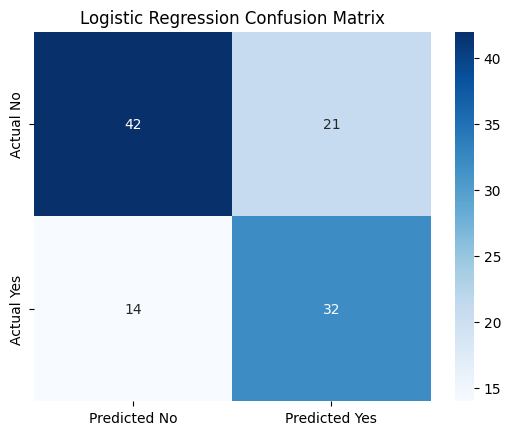

In [37]:
# Visualize the confusion matrix

cm_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.title('Logistic Regression Confusion Matrix')
plt.show()

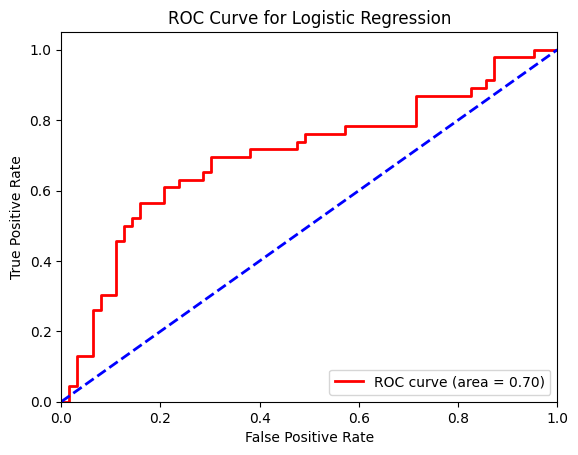

In [38]:
#Visualize the ROC Curve and AUC Score

# Calculate the ROC curve points
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, logreg_optimized.predict_proba(x_test)[:,1])

# Calculate the AUC
roc_auc = auc(fpr_logreg, tpr_logreg)

# Plot the figure
plt.figure()
plt.plot(fpr_logreg, tpr_logreg, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

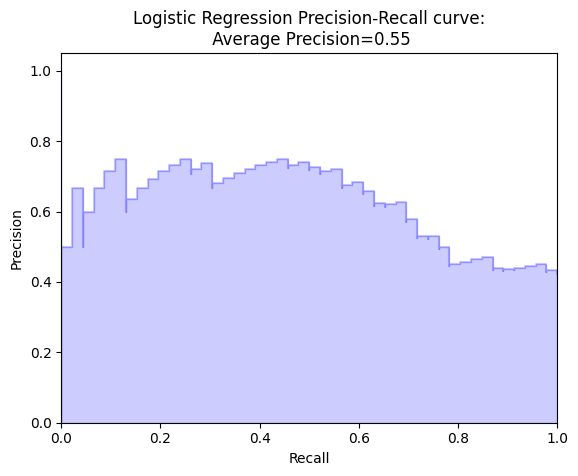

In [39]:
# Visualize the precision-recall curve

precision, recall, _ = precision_recall_curve(y_test, logreg_optimized.predict_proba(x_test)[:,1])
average_precision = average_precision_score(y_test, y_pred_logreg)

# Plot the figure
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Logistic Regression Precision-Recall curve:\n Average Precision={average_precision:.2f}')
plt.show()

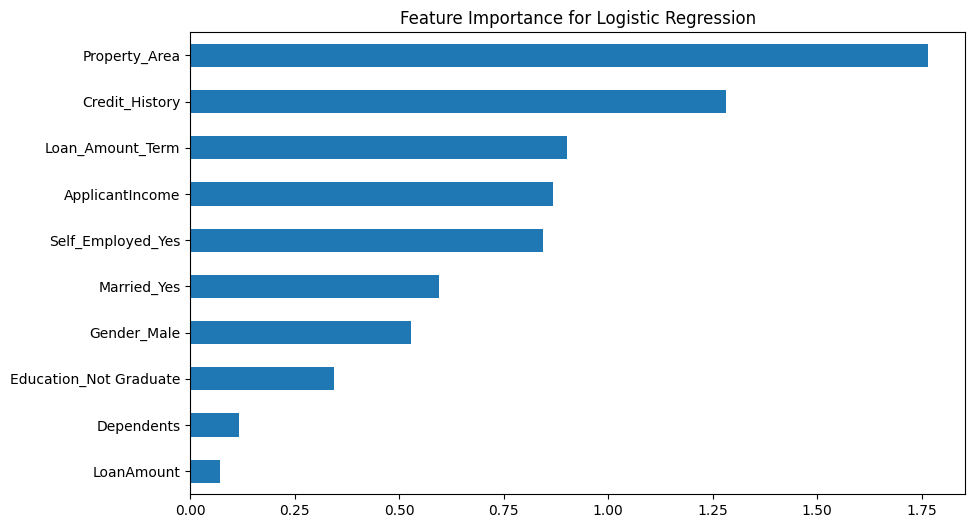

In [42]:
# Visualize the feature importance

feature_importance = pd.Series(index = x_columns, data = np.abs(logreg_optimized.coef_[0]))
feature_importance.nlargest(10).sort_values().plot(kind = 'barh', figsize = (10,6))
plt.title('Feature Importance for Logistic Regression')
plt.show()

## K-Nearest Neighbors Classifier (KNN)

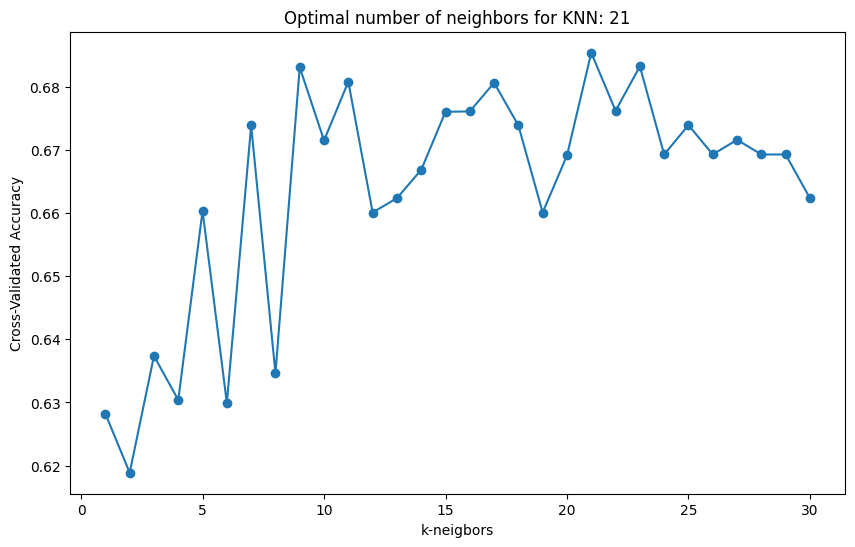

In [43]:
# Build a KNN classifier by tuning the optimal number of neighbors

# Define the range of neighbors to try
neighbor_range = range(1, 31)

# Create a list to store average cross-validation scores
cv_scores = []

# Perform 10-fold cross-validation for each number of neighbors
for n_neighbors in neighbor_range:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')  # 10-fold cross-validation
    cv_scores.append(scores.mean())

# Find the optimal number of neighbors
optimal_neighbors = neighbor_range[np.argmax(cv_scores)]

# Plot the relationship between K and cross-validation accuracy
plt.figure(figsize=(10,6))
plt.plot(neighbor_range, cv_scores, marker='o')
plt.xlabel('k-neigbors')
plt.ylabel('Cross-Validated Accuracy')
plt.title(f'Optimal number of neighbors for KNN: {optimal_neighbors}')
plt.show()

In [44]:
# Initialize and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=optimal_neighbors)
knn.fit(x_train, y_train)

# Make predictions on the test data
y_pred_knn = knn.predict(x_test)

# Evaluate the model
print("KNN Model Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

KNN Model Accuracy: 0.7064220183486238
Confusion Matrix:
 [[48 15]
 [17 29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75        63
           1       0.66      0.63      0.64        46

    accuracy                           0.71       109
   macro avg       0.70      0.70      0.70       109
weighted avg       0.70      0.71      0.71       109



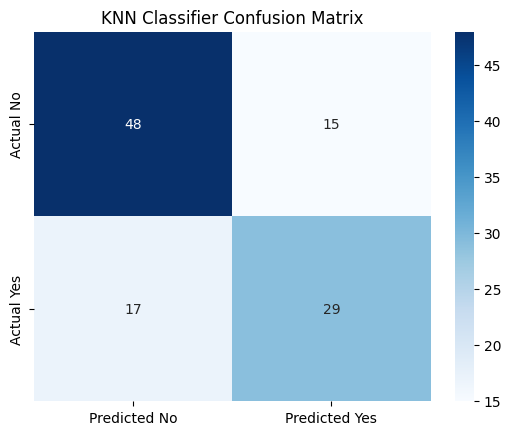

In [45]:
# Visualize the confusion matrix

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.title('KNN Classifier Confusion Matrix')
plt.show()

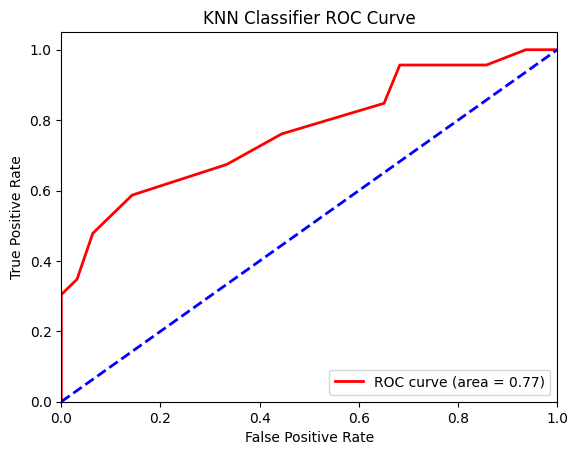

In [46]:
# Visualize the ROC curve and AUC score

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn.predict_proba(x_test)[:,1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure()
plt.plot(fpr_knn, tpr_knn, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Classifier ROC Curve')
plt.legend(loc="lower right")
plt.show()

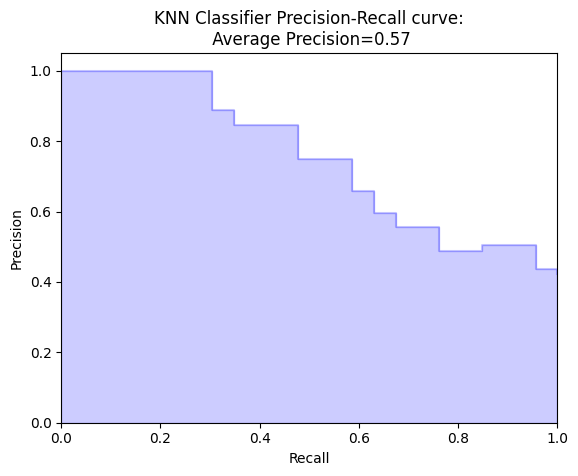

In [47]:
# Visualize the precision-recall curve

precision, recall, _ = precision_recall_curve(y_test, knn.predict_proba(x_test)[:,1])
average_precision = average_precision_score(y_test, y_pred_knn)

# Plot
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'KNN Classifier Precision-Recall curve:\n Average Precision={average_precision:.2f}')
plt.show()

## Random Forest Classifier

In [48]:
# Build a Random Forest Classifier by first tuning the hyperparameters

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=0)

# Perform a GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model with cross-validation
cv_scores = cross_val_score(best_rf_model, x_train, y_train, cv=10)
print("Cross-validated scores:", cv_scores)
print("Mean cross-validated score:", np.mean(cv_scores))

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validated accuracy: 0.8728858350951374
Cross-validated scores: [0.93181818 0.84090909 0.88636364 0.8372093  0.88372093 0.79069767
 0.8372093  0.93023256 0.88372093 0.90697674]
Mean cross-validated score: 0.8728858350951374


In [49]:
# Fit the model on the training data
best_rf_model.fit(x_train, y_train)

# Make predictions on the test data
y_pred_rf = best_rf_model.predict(x_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy: 0.8348623853211009
Confusion Matrix:
 [[48 15]
 [ 3 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84        63
           1       0.74      0.93      0.83        46

    accuracy                           0.83       109
   macro avg       0.84      0.85      0.83       109
weighted avg       0.86      0.83      0.84       109



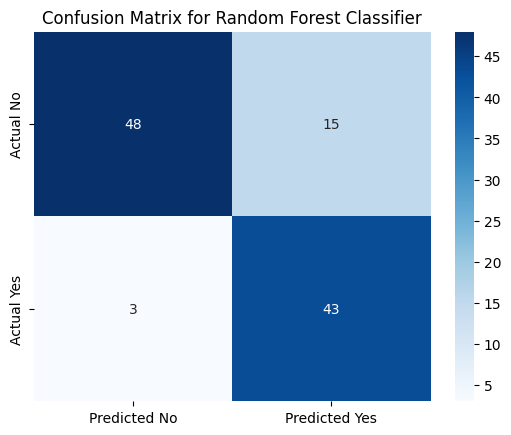

In [50]:
# Visualize the confusion matrix

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

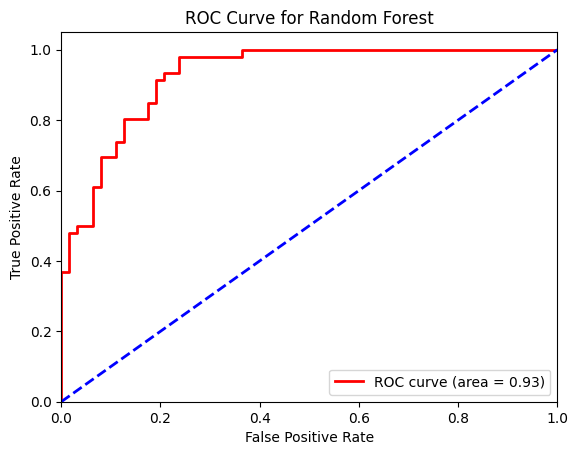

In [51]:
# Visualize the ROC curve and AUC score

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, best_rf_model.predict_proba(x_test)[:,1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the figure
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

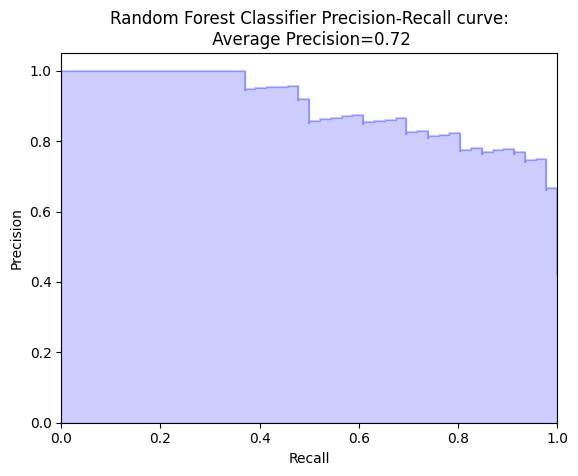

In [52]:
# Visualize the precision-recall curve

precision, recall, _ = precision_recall_curve(y_test, best_rf_model.predict_proba(x_test)[:,1])
average_precision = average_precision_score(y_test, y_pred_rf)

# Plot the figure
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Random Forest Classifier Precision-Recall curve:\n Average Precision={average_precision:.2f}')
plt.show()

## Extreme Gradient Boosting Classifier (XGBoost)

In [53]:
# Build an XGBoost Classifier by first tuning the hyperparameters

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the XGBClassifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

# Perform a GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

# Get the best model
best_xgb_model = grid_search.best_estimator_

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.6}
Best cross-validated accuracy: 0.870507399577167


In [54]:
# Fit the model on the training data
best_xgb_model.fit(x_train, y_train)

# Make predictions on the test data
y_pred_xgb = best_xgb_model.predict(x_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

Accuracy: 0.8256880733944955
Confusion Matrix:
 [[47 16]
 [ 3 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.75      0.83        63
           1       0.73      0.93      0.82        46

    accuracy                           0.83       109
   macro avg       0.83      0.84      0.83       109
weighted avg       0.85      0.83      0.83       109



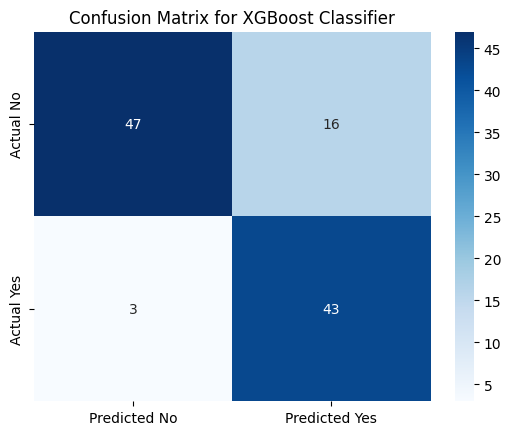

In [55]:
# Visualize the confusion matrix

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()

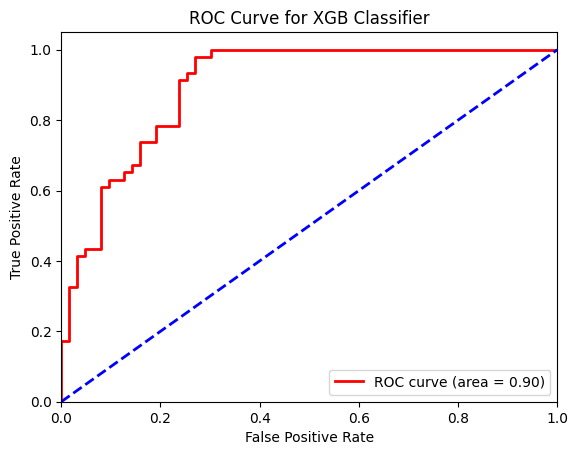

In [56]:
# Visualize the ROC Curve and AUC score

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, best_xgb_model.predict_proba(x_test)[:,1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot the figure
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGB Classifier')
plt.legend(loc="lower right")
plt.show()

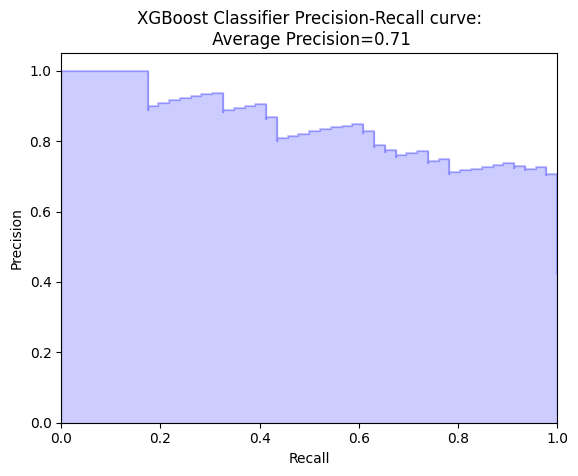

In [57]:
# Visualize the precision-recall curve

precision, recall, _ = precision_recall_curve(y_test, best_xgb_model.predict_proba(x_test)[:,1])
average_precision = average_precision_score(y_test, y_pred_xgb)

# Plot the figure
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'XGBoost Classifier Precision-Recall curve:\n Average Precision={average_precision:.2f}')
plt.show()